In [1]:
%load_ext autoreload
%autoreload 2

In [143]:
from curvey import Curve, Curves, ShapeStructureDataset
from curvey.flow import WillmoreFlow
from curvey.blend import Pair, CurvatureShapeBlending, LinearBlending
from matplotlib import pyplot as plt
import numpy as np
# from numpy import *

To demonstrate shape blending we'll use a couple of examples from the Shape Structure Dataset:

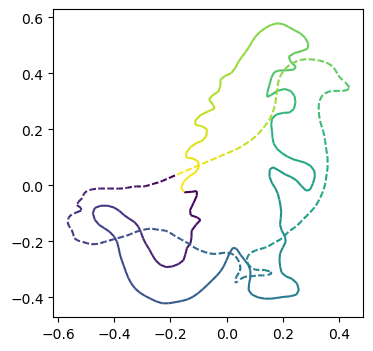

In [144]:
dataset = ShapeStructureDataset("~/Downloads/ShapesJSON.zip")

# Load curves and center them so they're reasonably well-aligned, 
# make sure they have the same orientation, and resample both 
# to the same number of vertices
src = (
    dataset.load_curve('dino', 0)
    .translate('center')
    .to_ccw()
    .resample(n=200)
)
tgt = (
    dataset.load_curve('bird', 8)
    .reflect('y')
    .to_ccw()
    .translate('center')
    .resample(n=200)
)

# Finds the best vertex in the `tgt` shape to call the first vertex, to
# minimize the sum of square distances between corresponding vertices
tgt = tgt.roll_to(src)

_ = plt.subplots(figsize=(4, 4))
_ = src.plot_edges(directed=False)
_ = tgt.plot_edges(directed=False, linestyle='-:')

## Linear blending

Linear blending is extremely fast and simple, and requires only that the curves have the same number of vertices. (This can be done manually as above, or with `JointSampled.to_common_vertex_count`, which will simply split edges in the fewer-vertices curve until the counts match.)

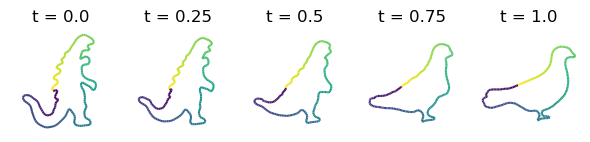

In [148]:
lb = LinearBlending(src, tgt)
lin_blend_curves = lb.interpolate(t=np.linspace(0, 1, 5))
_ = lin_blend_curves.subplots(figsize=(6, 4), subtitle=lambda c: f"t = {c['time']}")

The weakness of linear blending is that it can difficult to avoid small self intersections.

In [149]:
for c in lin_blend_curves:
    if not c.is_simple:
        print(c)
        print(c.edge_intersections())

Curve(n=200, time=0.5, idx=2)
[[0.25351013 0.32599915]]


## Curvature blending

Based on [*Rapid blending of closed curves based on curvature flow.* Masahiro Hirano, Yoshihiro Watanabe, and 
Masatoshi Ishikawa. 2017.](https://www.sciencedirect.com/science/article/pii/S016783961730016X).

Curvature blending uses Willmore flow. Instead of interpolating between vertex coordinates, it interpolates between vertex curvatures. For this to work, we'll need more than just the number of vertices to match—because Willmore flow operates isometrically, we'll need the total arclengths and individual edge lengths to match. `Pair.to_common_edge_length` rescales both input curves to length 1.0, and optimizes the distribution of vertices along the curves. We then store the original and processed pairs in a `Pair` object to pass to `CurvatureShapeBlending` so it has convenient access to both the original and rescaled curves.

In [150]:
src1, tgt1 = Pair.to_common_edge_length(src, tgt)
pair = Pair.from_pairs(src, src1, tgt, tgt1)
pair

Pair(
    Processed(orig=Curve(n=200), processed=Curve(n=200)), 
    Processed(orig=Curve(n=200), processed=Curve(n=200)), 
)

In the Hirano et al. paper, they describe first flowing from the initial source shape to the first interpolated curvatures, from that to the second, and so on to the final target shape curvatures. I've found that this approach is vulnerable to getting 'stuck' in the middle, and never really hitting the final target shape. Instead, we'll first flow the initial source shape to a circle, and then flow that circle to each interpolated curvature independently. (The original approach is still available by using the `path_dependent` argument to `CurvatureShapeBlending.interpolate`.)

In [152]:
wf = WillmoreFlow()
solver = wf.solver(initial=pair[0].processed, stop_tol=1e-3)
circle = solver.run().current

The `CurvatureShapeBlending` class uses target Willmore flow to flow from the initial shape, in this case that circle, to a number of intermediate curvatures $\kappa_t = (1 - t) \kappa_0 + t \kappa_1$. Because it does the flow on the rescaled curves, it will then rescale the interpolated curve back to a length or area interpolated from the original curves.

In [167]:
csb = CurvatureShapeBlending(pair=pair, initial=circle, flow=wf)
t_interp = np.linspace(0, 1, 5)
curv_blend_curves = csb.interpolate(t=t_interp, stop_tol=1e-3, interp_size='area')

`CurvatureShapeBlending.interpolate` returns a `Curves` object containing the interpolated curves:

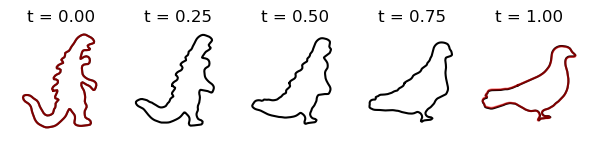

In [168]:
axs = curv_blend_curves.subplots(
    figsize=(6, 3), 
    plot_fn=lambda c: c.plot(color='black'),
    subtitle=lambda c: f"t = {c['time']:.02f}"
);
_ = src.plot(color='red', ax=axs[0, 0], alpha=0.5)
_ = tgt.plot(color='red', ax=axs[0, -1], alpha=0.5)

The original curves are shown above in red at `t=0` and `t=1`, overlayed by the interpolated shapes, showing the curvature interpolation doesn't exactly hit its endpoint targets, but gets pretty close. (You can pass `exact_endpoints=(True, True)` to `CurvatureShapeBlending.interpolate` to have it automatically return the original curves at `t=0` and `t=1` instead of using curvature flow on those endpoints.)

`CurvatureShapeBlending.interpolate` stores three curve metadata properties on the interpolated curves:
- `src_error`: $e(\tilde \kappa - \kappa_0)$
- `tgt_error` $e(\tilde \kappa - \kappa_1)$
- `interp_error`$e(\tilde \kappa - \kappa_t)$

Where $\tilde \kappa$ is the observed curvature at that interpolation point, $\kappa_0$ and $\kappa_1$ are the start and end curvatures to interpolate between, and $\kappa_t = (1 - t) \kappa_0 + t \kappa_1$ are the interpolated curvatures, and the error $e(\kappa)$ is

$$
e(\kappa) = \left( \sum_i \kappa_i^2 d_i \right) ^ {1/2}
$$

for vertex dual edge lengths $d_i$, i.e. the error is the $\mathscr{L}^2$ norm of the difference in curvatures.

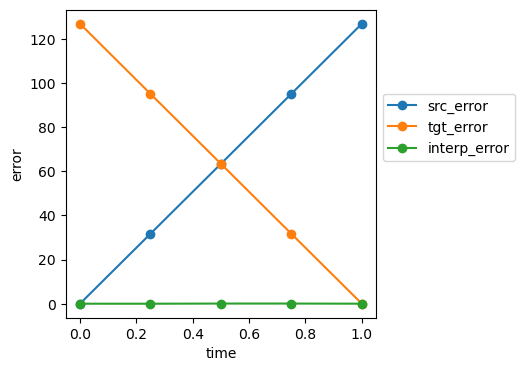

In [178]:
_ = plt.subplots(figsize=(4, 4))
curv_blend_curves.plot('src_error', marker='o')
curv_blend_curves.plot('tgt_error', marker='o')
curv_blend_curves.plot('interp_error', marker='o')
_ = plt.gca().set_ylabel('error')
_ = plt.legend(bbox_to_anchor=(1, .75))